# Классификация персонажей Marvel

## Загрузка библиотек и необходимых модулей

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix


## Загрузка данных
Загрузим набор данных `marvel-wikia-data.csv`

In [3]:
# Загрузка данных
df = pd.read_csv("marvel-wikia-data.csv")
print("Размер данных:", df.shape)
df.head()

Размер данных: (16376, 13)


,page_id,name,urlslug,ID,ALIGN,EYE,HAIR,SEX,GSM,ALIVE,APPEARANCES,FIRST APPEARANCE,Year
0,1678,Spider-Man (Peter Parker),\/Spider-Man_(Peter_Parker),Secret Identity,Good Characters,Hazel Eyes,Brown Hair,Male Characters,NaN,Living Characters,4043.0,Aug-62,1962.0
1,7139,Captain America (Steven Rogers),\/Captain_America_(Steven_Rogers),Public Identity,Good Characters,Blue Eyes,White Hair,Male Characters,NaN,Living Characters,3360.0,Mar-41,1941.0
2,64786,"Wolverine (James \""Logan\"" Howlett)",\/Wolverine_(James_%22Logan%22_Howlett),Public Identity,Neutral Characters,Blue Eyes,Black Hair,Male Characters,NaN,Living Characters,3061.0,Oct-74,1974.0
3,1868,"Iron Man (Anthony \""Tony\"" Stark)",\/Iron_Man_(Anthony_%22Tony%22_Stark),Public Identity,Good Characters,Blue Eyes,Black Hair,Male Characters,NaN,Living Characters,2961.0,Mar-63,1963.0
4,2460,Thor (Thor Odinson),\/Thor_(Thor_Odinson),No Dual Identity,Good Characters,Blue Eyes,Blond Hair,Male Characters,NaN,Living Characters,2258.0,Nov-50,1950.0


## Предварительный анализ и отбор целевой переменной
Целевой переменной в данной задаче выберем `SEX` — пол персонажа. Ограничим данные только строками, где явно указан пол (мужской или женский).

In [4]:
# Удалим строки с неопределенным полом
df = df[df['SEX'].isin(['Male Characters', 'Female Characters'])]

## Выбор признаков
Выбираем информативные признаки, которые, по нашему мнению, могут повлиять на пол персонажа, такие как выравнивание, цвет глаз и волос, статус, число появлений и дата первого появления.

In [5]:
# Упрощение и отбор признаков
features = ['ALIGN', 'EYE', 'HAIR', 'GSM', 'ALIVE', 'APPEARANCES', 'FIRST APPEARANCE']
X = df[features]
y = df['SEX']

## Обработка пропусков
Пропущенные значения будут заполнены наиболее частыми (модой) для соответствующего признака.

In [6]:
# Обработка пропусков
imputer = SimpleImputer(strategy='most_frequent')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

## Преобразование числовых признаков
- `APPEARANCES`: приводим к числовому типу
- `FIRST APPEARANCE`: извлекаем только год из строки и также приводим к числу

In [7]:
# Обработка числовых признаков
X_imputed['APPEARANCES'] = pd.to_numeric(X_imputed['APPEARANCES'], errors='coerce').fillna(0).astype(int)
X_imputed['FIRST APPEARANCE'] = pd.to_numeric(X_imputed['FIRST APPEARANCE'].str.extract(r'(\d{4})')[0], errors='coerce').fillna(0).astype(int)

## Кодирование признаков
- Категориальные признаки кодируются с помощью `pd.get_dummies`
- Целевая переменная кодируется через `LabelEncoder` (0 — Female, 1 — Male)

In [8]:
# Кодирование категориальных признаков
X_encoded = pd.get_dummies(X_imputed)

## Разделение данных на обучающую и тестовую выборки
Тестовая выборка составит 20% от всего набора. Обучение будет проводиться на 80%.

In [9]:
# Кодирование целевой переменной
y_encoded = LabelEncoder().fit_transform(y)

## Масштабирование признаков
Для метода опорных векторов важно масштабировать признаки. Мы применим `StandardScaler` только к признакам, переданных в SVM.

In [10]:
# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=42)

## Обучение моделей
Мы обучим две модели:
- Support Vector Machine (SVM)
- Random Forest Classifier

In [11]:
# Масштабирование данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [14]:
# Модель 1: Линейная/логистическая регрессия
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_scaled, y_train)
lr_preds = lr_model.predict(X_test_scaled)

In [15]:
# Модель 2: Градиентный бустинг
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)
gb_preds = gb_model.predict(X_test)

## Оценка качества моделей
Оценим модели с использованием метрик:
- **Accuracy** — доля верных предсказаний
- **F1 Score** — гармоническое среднее точности и полноты, особенно важно при дисбалансе классов

In [18]:
# Метрики качества
print("--- Линейная/логистическая регрессия ---")
print("Accuracy:", accuracy_score(y_test, lr_preds))
print("F1 Score:", f1_score(y_test, lr_preds))
cm_lr = confusion_matrix(y_test, lr_preds)

print("\n--- Градиентный бустинг ---")
print("Accuracy:", accuracy_score(y_test, gb_preds))
print("F1 Score:", f1_score(y_test, gb_preds))
cm_gb = confusion_matrix(y_test, gb_preds)

--- Линейная/логистическая регрессия ---
Accuracy: 0.7634894991922455
F1 Score: 0.8580294802172227

--- Градиентный бустинг ---
Accuracy: 0.7638126009693054
F1 Score: 0.8606291706387035


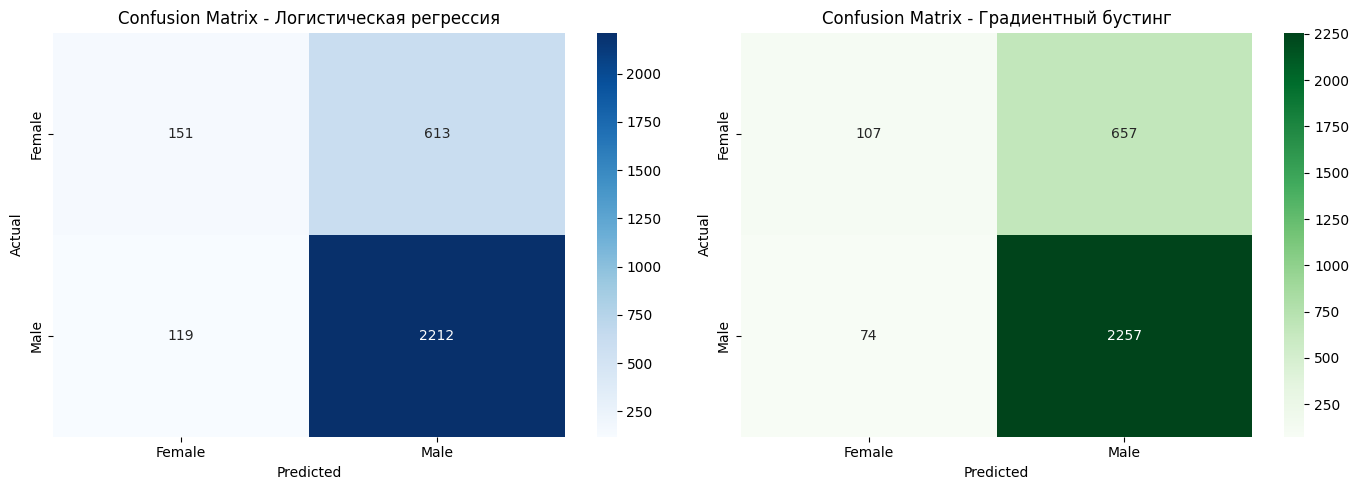

In [19]:
# Визуализация матриц ошибок
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Линейная/логистическая регрессия
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=axs[0])
axs[0].set_title('Confusion Matrix - Логистическая регрессия')
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('Actual')
axs[0].set_xticklabels(['Female', 'Male'])
axs[0].set_yticklabels(['Female', 'Male'])

# Градиентный бустинг
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Greens', ax=axs[1])
axs[1].set_title('Confusion Matrix - Градиентный бустинг')
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('Actual')
axs[1].set_xticklabels(['Female', 'Male'])
axs[1].set_yticklabels(['Female', 'Male'])

plt.tight_layout()
plt.show()

### Вывод:
- **Линейная/логистическая регрессия** показывает базовое качество классификации, простая в реализации и интерпретации.
- **Градиентный бустинг** обеспечивает более высокую точность и F1-мегрику, особенно при наличии сложных зависимостей между признаками.
- В условиях дисбаланса классов (больше мужских персонажей), **F1 Score** остаётся приоритетной метрикой для объективной оценки модели.
